In [1]:
!pip install scikit-learn==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


In [3]:
data = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
data.info()
data.describe()
data['default.payment.next.month'].value_counts()
# 1: default, 0: not default


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

In [5]:
data = data.drop(columns=["ID"])
X = data.drop(columns=["default.payment.next.month"])
y = data["default.payment.next.month"]
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

[[4385  288]
 [ 842  485]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.37      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

ROC-AUC: 0.7582


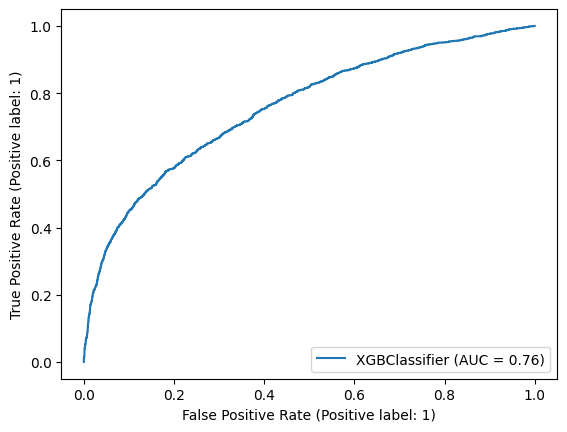

In [11]:

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

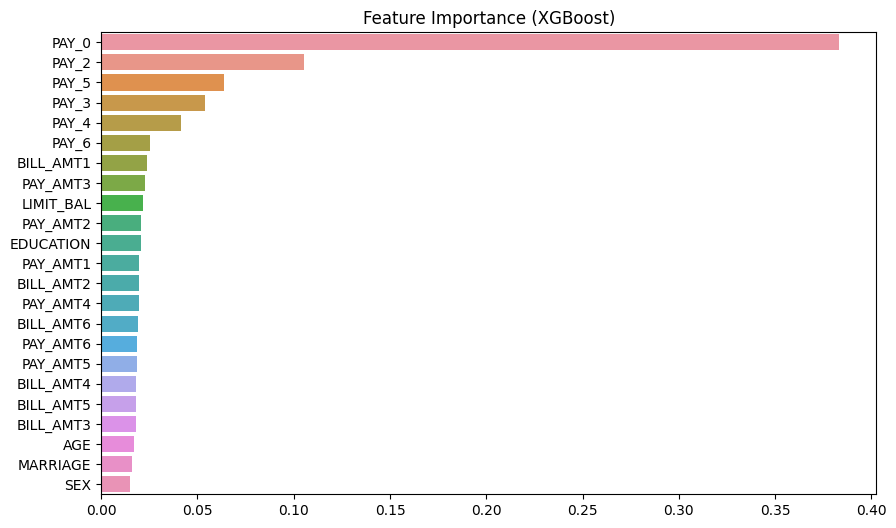

In [12]:
importances = model.feature_importances_
feature_names = data.columns[:-1]

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (XGBoost)")
plt.show()


In [13]:
X["TOTAL_PAY_AMT"] = X[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", 
                          "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]].sum(axis=1)

X["TOTAL_BILL_AMT"] = X[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
                           "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]].sum(axis=1)

# X["PAY_RATIO"] = X["TOTAL_PAY_AMT"] / (X["TOTAL_BILL_AMT"] + 1)
# X.head()


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

[[4379  294]
 [ 844  483]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.62      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

ROC-AUC: 0.7574


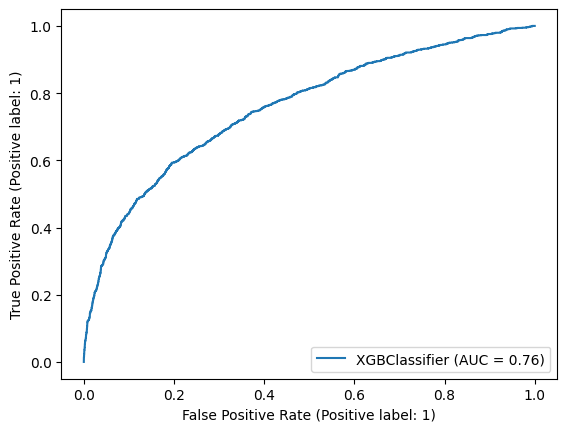

In [15]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

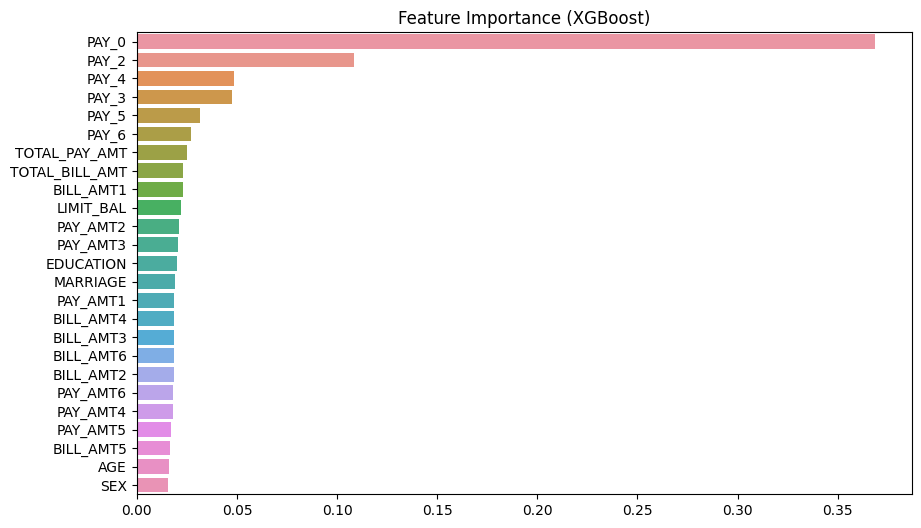

In [16]:
importances = model.feature_importances_
feature_names = X.columns 

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [17]:
def longest_late_streak(row):
    streak = 0
    max_streak = 0
    for val in row:
        if val > 0:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak
    
X["NUM_LATE_PAYMENTS"] = X[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].apply(
    lambda row: sum(row > 0), axis=1)

X["MAX_DELAY"] = X[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].apply(
    lambda row: max(row), axis=1)

X["LONGEST_LATE_STREAK"] = X[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].apply(
    longest_late_streak, axis=1)


In [18]:
#optimize with gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
}


In [19]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best AUC:", grid.best_score_)


Before SMOTE: default.payment.next.month
0    18691
1     5309
Name: count, dtype: int64
After SMOTE: default.payment.next.month
0    18691
1    18691
Name: count, dtype: int64
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

In [21]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC: {auc:.4f}")


Test ROC-AUC: 0.7803


In [22]:
import sklearn
import xgboost
# import imblearn as il
print("scikit-learn version:", sklearn.__version__)
print("xgboost version:", xgboost.__version__)
# print("imbalanced version:", il.__version__)


scikit-learn version: 1.3.2
xgboost version: 2.0.3


In [23]:
# X["AVG_BILL_AMT"] = X[["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]].mean(axis=1)
# X["STD_BILL_AMT"] = X[["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]].std(axis=1)

# X["MEAN_PAY_RATIO"] = (
#     X[["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]].mean(axis=1) /
#     (X["AVG_BILL_AMT"] + 1)
# )

# X["STD_PAY_AMT"] = X[["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]].std(axis=1)
# X["NUM_ON_TIME"] = X[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].apply(
#     lambda row: sum(row <= 0), axis=1)
